In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches


In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
combined

,scardec_name,isc_name,year,month,day,hour,minute,second,latitude,longitude,depth,scardec_magnitude,scardec_mag_type,moment,isc_magnitude,isc_mag_type,isc_mag_unc,days_count
0,FCTs_19920120_133703_BONIN_ISLANDS__JAPAN_REGION,NaN,1992,1,20,13,37,3.0,27.980,139.400,522.0,6.566,mw,8.882000e+18,NaN,NaN,NaN,19
1,FCTs_19920213_012913_VANUATU_ISLANDS,NaN,1992,2,13,1,29,13.0,-15.890,166.320,20.0,6.716,mw,1.493000e+19,NaN,NaN,NaN,43
2,FCTs_19920305_143910_OFF_EAST_COAST_OF_KAMCHATKA,NaN,1992,3,5,14,39,10.0,52.900,159.620,53.0,6.305,mw,3.607000e+18,NaN,NaN,NaN,64
3,FCTs_19920307_015337_COSTA_RICA,NaN,1992,3,7,1,53,37.0,10.210,-84.320,79.0,6.485,mw,6.732000e+18,NaN,NaN,NaN,66
4,FCTs_19920313_160104_ANDREANOF_ISLANDS__ALEUTI...,NaN,1992,3,13,16,1,4.0,52.450,-178.950,214.0,6.415,mw,5.273000e+18,NaN,NaN,NaN,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,FCTs_20221208_005055_JAVA__INDONESIA,NaN,2022,12,8,0,50,55.0,-6.711,107.146,110.0,5.777,mw,5.834000e+17,NaN,NaN,NaN,11299
4179,FCTs_20221211_143129_GUERRERO__MEXICO,NaN,2022,12,11,14,31,29.0,17.180,-100.530,22.0,5.996,mw,1.243000e+18,NaN,NaN,NaN,11302
4180,FCTs_20221214_184026_RAT_ISLANDS__ALEUTIAN_ISL...,NaN,2022,12,14,18,40,26.0,51.608,178.597,81.0,6.274,mw,3.240000e+18,NaN,NaN,NaN,11305
4181,FCTs_20221220_103424_NEAR_COAST_OF_NORTHERN_CALIF,NaN,2022,12,20,10,34,24.0,40.525,-124.423,7.0,6.323,mw,3.840000e+18,NaN,NaN,NaN,11311


In [5]:
def moment_in_different_windows(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctopt')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_opt.append(float(split[0]))
            momentrate_opt.append(float(split[1]))

        momentrate_opt = np.array(momentrate_opt)

        not_zero = np.where(momentrate_opt > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        trapz.append(scipy.integrate.trapz(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int(len(not_zero)*(window/max(time_opt)))
        else:
            end_window = int(len(not_zero)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_opt[start:start + end_window], dx = time_opt[1]-time_opt[0]))
    return moments, simpson, simpson_short, trapz, durations

In [40]:
import sklearn.preprocessing
import sklearn.pipeline
import scipy.spatial
import numpy as np


def calculate_hull(
        X,
        scale=1.1,
        padding="scale",
        n_interpolate=100,
        interpolation="quadratic_periodic",
        return_hull_points=False):
    """
    Calculates a "smooth" hull around given points in `X`.
    The different settings have different drawbacks but the given defaults work reasonably well.
    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"

    Inspired by: https://stackoverflow.com/a/17557853/991496
    """

    if padding == "scale":

        # scaling based padding
        scaler = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(with_std=False),
            sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)))
        points_scaled = scaler.fit_transform(X) * scale
        hull_scaled = scipy.spatial.ConvexHull(points_scaled, incremental=True)
        hull_points_scaled = points_scaled[hull_scaled.vertices]
        hull_points = scaler.inverse_transform(hull_points_scaled)
        hull_points = np.concatenate([hull_points, hull_points[:1]])

    elif padding == "extend" or isinstance(padding, (float, int)):
        # extension based padding
        # TODO: remove?
        if padding == "extend":
            add = (scale - 1) * np.max([
                X[:,0].max() - X[:,0].min(),
                X[:,1].max() - X[:,1].min()])
        else:
            add = padding
        points_added = np.concatenate([
            X + [0,add],
            X - [0,add],
            X + [add, 0],
            X - [add, 0]])
        hull = scipy.spatial.ConvexHull(points_added)
        hull_points = points_added[hull.vertices]
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    else:
        raise ValueError(f"Unknown padding mode: {padding}")

    # number of interpolated points
    nt = np.linspace(0, 1, n_interpolate)

    x, y = hull_points[:,0], hull_points[:,1]

    # ensures the same spacing of points between all hull points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2)
    t = np.cumsum(t)
    t /= t[-1]

    # interpolation types
    if interpolation is None or interpolation == "linear":
        x2 = scipy.interpolate.interp1d(t, x, kind="linear")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="linear")(nt)
    elif interpolation == "quadratic":
        x2 = scipy.interpolate.interp1d(t, x, kind="quadratic")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="quadratic")(nt)

    elif interpolation == "quadratic_periodic":
        x2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, x, per=True, k=4))
        y2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, y, per=True, k=4))

    elif interpolation == "cubic":
        x2 = scipy.interpolate.CubicSpline(t, x, bc_type="periodic")(nt)
        y2 = scipy.interpolate.CubicSpline(t, y, bc_type="periodic")(nt)
    else:
        x2 = interpolation(t, x, nt)
        y2 = interpolation(t, y, nt)

    X_hull = np.concatenate([x2.reshape(-1,1), y2.reshape(-1,1)], axis=1)
    if return_hull_points:
        return X_hull, hull_points
    else:
        return X_hull


def draw_hull(
        X,
        scale=1.1,
        padding="scale",
        n_interpolate=100,
        interpolation="quadratic_periodic",
        plot_kwargs=None,
        ax=None):
    """Uses `calculate_hull` to draw a hull around given points.

    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"
    plot_kwargs : dict, optional
        `matplotlib.pyplot.plot` kwargs, by default None
    ax : `matplotlib.axes.Axes`, optional
        [description], by default None
    """

    if plot_kwargs is None:
        plot_kwargs = {}

    X_hull = calculate_hull(
        X, scale=scale, padding=padding, n_interpolate=n_interpolate, interpolation=interpolation)
    if ax is None:
        ax= plt.gca()
    plt.plot(X_hull[:,0], X_hull[:,1], **plot_kwargs)


def draw_rounded_hull(X, padding=0.1, line_kwargs=None, ax=None):
    """Plots a convex hull around points with rounded corners and a given padding.

    Parameters
    ----------
    X : np.array
        2d array with two columns and n rows
    padding : float, optional
        padding between hull and points, by default 0.1
    line_kwargs : dict, optional
        line kwargs (used for `matplotlib.pyplot.plot` and `matplotlib.patches.Arc`), by default None
    ax : matplotlib.axes.Axes, optional
        axes to plat on, by default None
    """

    default_line_kwargs = dict(
        color="black",
        linewidth=1
    )
    if line_kwargs is None:
        line_kwargs = default_line_kwargs
    else:
        line_kwargs = {**default_line_kwargs, **line_kwargs}

    if ax is None:
        ax = plt.gca()

    hull = scipy.spatial.ConvexHull(X)
    hull_points = X[hull.vertices]

    hull_points = np.concatenate([hull_points[[-1]], hull_points, hull_points[[0]]])

    diameter = padding * 2
    for i in range(1, hull_points.shape[0] - 1):

        # line

        # source: https://stackoverflow.com/a/1243676/991496

        norm_next = np.flip(hull_points[i] - hull_points[i + 1]) * [-1, 1]
        norm_next /= np.linalg.norm(norm_next)

        norm_prev = np.flip(hull_points[i - 1] - hull_points[i]) * [-1, 1]
        norm_prev /= np.linalg.norm(norm_prev)

        # plot line
        line = hull_points[i:i+2] + norm_next * diameter / 2
        ax.plot(line[:,0], line[:,1], **line_kwargs)

        # arc

        angle_next = np.rad2deg(np.arccos(np.dot(norm_next, [1,0])))
        if norm_next[1] < 0:
            angle_next = 360 - angle_next

        angle_prev = np.rad2deg(np.arccos(np.dot(norm_prev, [1,0])))
        if norm_prev[1] < 0:
            angle_prev = 360 - angle_prev

        arc = patches.Arc(
            hull_points[i],
            diameter, diameter,
            angle=0, fill=False, theta1=angle_prev, theta2=angle_next,
            **line_kwargs)

        ax.add_patch(arc)



0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001


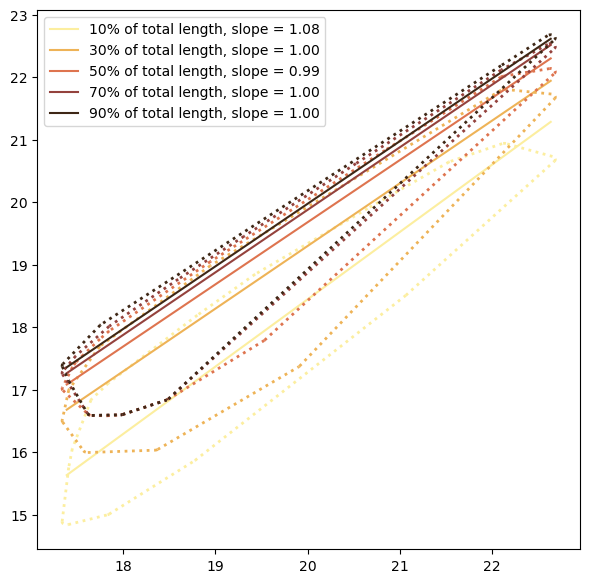

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))

#window_prop = 0.1
for window_prop in np.arange(0.1, 1.1, 0.2):
        print(window_prop)
        moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window_prop = window_prop)
        durations = np.array(durations)
        moments = np.array(moments)
        simpson_short = np.array(simpson_short)

        not_zero = np.where(simpson_short > 0)[0]

        result = scipy.stats.linregress(np.log10(moments[not_zero]), np.log10(simpson_short[not_zero]))

        x_plot = np.log10(np.logspace(np.log10(min(moments)), np.log10(max(moments))))

        ax.plot(x_plot, result.intercept + x_plot*result.slope,
                label = f'{window_prop * 100:.0f}% of total length, slope = {result.slope:.2f}',
                alpha = 1,
                color = cmc.lajolla(window_prop))


        # plt.ylabel(f'Simpson window = {window_prop * 100:.0f}% of total length')
        # plt.xlabel('Final moment')
        # plt.colorbar(extend='max', label='log10(duration)')

        # np.random.seed(42)
        x = np.log10(moments[not_zero])
        y = np.log10(simpson_short[not_zero])
        X = np.dstack([x, y])[0]

        #plt.scatter(x, y, color = cmc.lajolla(window_prop), label = f'{window_prop * 100:.0f}% of total length', alpha = 0.5)

        draw_rounded_hull(X, padding=0.05, ax = ax, line_kwargs = {"color": cmc.lajolla(window_prop), "linewidth": 2, "linestyle": ":"})

plt.legend()
fig.show()

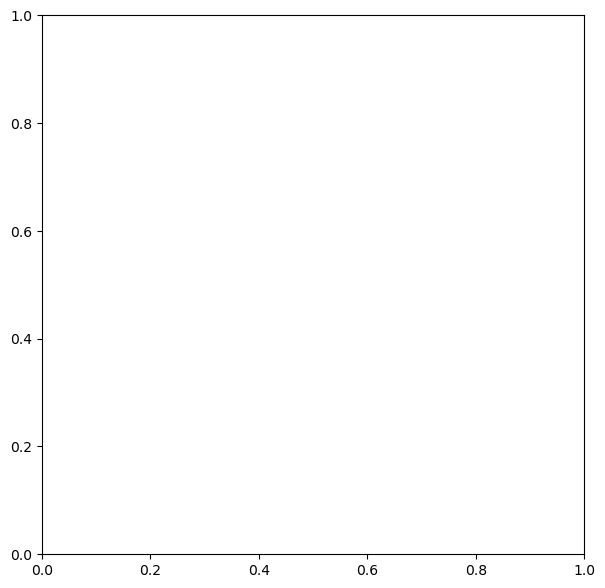

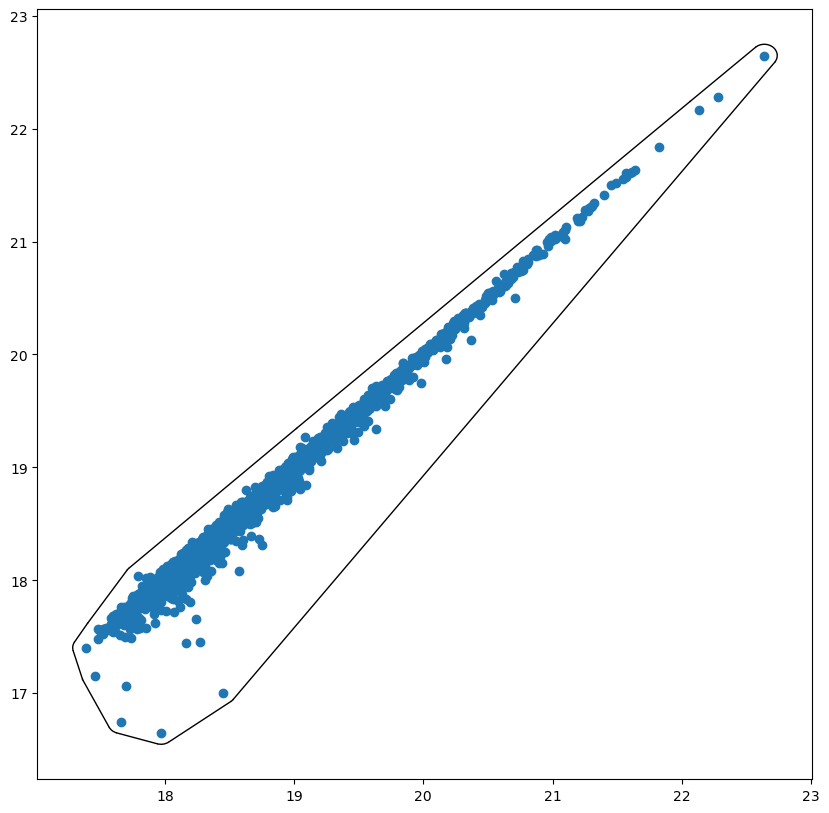

In [124]:
import sklearn.preprocessing
import sklearn.pipeline
import scipy.spatial
import numpy as np


def calculate_hull(
        X,
        scale=1.1,
        padding="scale",
        n_interpolate=100,
        interpolation="quadratic_periodic",
        return_hull_points=False):
    """
    Calculates a "smooth" hull around given points in `X`.
    The different settings have different drawbacks but the given defaults work reasonably well.
    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"

    Inspired by: https://stackoverflow.com/a/17557853/991496
    """

    if padding == "scale":

        # scaling based padding
        scaler = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(with_std=False),
            sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)))
        points_scaled = scaler.fit_transform(X) * scale
        hull_scaled = scipy.spatial.ConvexHull(points_scaled, incremental=True)
        hull_points_scaled = points_scaled[hull_scaled.vertices]
        hull_points = scaler.inverse_transform(hull_points_scaled)
        hull_points = np.concatenate([hull_points, hull_points[:1]])

    elif padding == "extend" or isinstance(padding, (float, int)):
        # extension based padding
        # TODO: remove?
        if padding == "extend":
            add = (scale - 1) * np.max([
                X[:,0].max() - X[:,0].min(),
                X[:,1].max() - X[:,1].min()])
        else:
            add = padding
        points_added = np.concatenate([
            X + [0,add],
            X - [0,add],
            X + [add, 0],
            X - [add, 0]])
        hull = scipy.spatial.ConvexHull(points_added)
        hull_points = points_added[hull.vertices]
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    else:
        raise ValueError(f"Unknown padding mode: {padding}")

    # number of interpolated points
    nt = np.linspace(0, 1, n_interpolate)

    x, y = hull_points[:,0], hull_points[:,1]

    # ensures the same spacing of points between all hull points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2)
    t = np.cumsum(t)
    t /= t[-1]

    # interpolation types
    if interpolation is None or interpolation == "linear":
        x2 = scipy.interpolate.interp1d(t, x, kind="linear")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="linear")(nt)
    elif interpolation == "quadratic":
        x2 = scipy.interpolate.interp1d(t, x, kind="quadratic")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="quadratic")(nt)

    elif interpolation == "quadratic_periodic":
        x2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, x, per=True, k=4))
        y2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, y, per=True, k=4))

    elif interpolation == "cubic":
        x2 = scipy.interpolate.CubicSpline(t, x, bc_type="periodic")(nt)
        y2 = scipy.interpolate.CubicSpline(t, y, bc_type="periodic")(nt)
    else:
        x2 = interpolation(t, x, nt)
        y2 = interpolation(t, y, nt)

    X_hull = np.concatenate([x2.reshape(-1,1), y2.reshape(-1,1)], axis=1)
    if return_hull_points:
        return X_hull, hull_points
    else:
        return X_hull


def draw_hull(
        X,
        scale=1.1,
        padding="scale",
        n_interpolate=100,
        interpolation="quadratic_periodic",
        plot_kwargs=None,
        ax=None):
    """Uses `calculate_hull` to draw a hull around given points.

    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"
    plot_kwargs : dict, optional
        `matplotlib.pyplot.plot` kwargs, by default None
    ax : `matplotlib.axes.Axes`, optional
        [description], by default None
    """

    if plot_kwargs is None:
        plot_kwargs = {}

    X_hull = calculate_hull(
        X, scale=scale, padding=padding, n_interpolate=n_interpolate, interpolation=interpolation)
    if ax is None:
        ax= plt.gca()
    plt.plot(X_hull[:,0], X_hull[:,1], **plot_kwargs)


def draw_rounded_hull(X, padding=0.1, line_kwargs=None, ax=None):
    """Plots a convex hull around points with rounded corners and a given padding.

    Parameters
    ----------
    X : np.array
        2d array with two columns and n rows
    padding : float, optional
        padding between hull and points, by default 0.1
    line_kwargs : dict, optional
        line kwargs (used for `matplotlib.pyplot.plot` and `matplotlib.patches.Arc`), by default None
    ax : matplotlib.axes.Axes, optional
        axes to plat on, by default None
    """

    default_line_kwargs = dict(
        color="black",
        linewidth=1
    )
    if line_kwargs is None:
        line_kwargs = default_line_kwargs
    else:
        line_kwargs = {**default_line_kwargs, **line_kwargs}

    if ax is None:
        ax = plt.gca()

    hull = scipy.spatial.ConvexHull(X)
    hull_points = X[hull.vertices]

    hull_points = np.concatenate([hull_points[[-1]], hull_points, hull_points[[0]]])

    diameter = padding * 2
    for i in range(1, hull_points.shape[0] - 1):

        # line

        # source: https://stackoverflow.com/a/1243676/991496

        norm_next = np.flip(hull_points[i] - hull_points[i + 1]) * [-1, 1]
        norm_next /= np.linalg.norm(norm_next)

        norm_prev = np.flip(hull_points[i - 1] - hull_points[i]) * [-1, 1]
        norm_prev /= np.linalg.norm(norm_prev)

        # plot line
        line = hull_points[i:i+2] + norm_next * diameter / 2
        ax.plot(line[:,0], line[:,1], **line_kwargs)

        # arc

        angle_next = np.rad2deg(np.arccos(np.dot(norm_next, [1,0])))
        if norm_next[1] < 0:
            angle_next = 360 - angle_next

        angle_prev = np.rad2deg(np.arccos(np.dot(norm_prev, [1,0])))
        if norm_prev[1] < 0:
            angle_prev = 360 - angle_prev

        arc = patches.Arc(
            hull_points[i],
            diameter, diameter,
            angle=0, fill=False, theta1=angle_prev, theta2=angle_next,
            **line_kwargs)

        ax.add_patch(arc)





fig, ax = plt.subplots(figsize=(7, 7))
# np.random.seed(42)
x = np.log10(np.array(moments))
y = np.log10(np.array(simpson_short))
X = np.dstack([x, y])[0]
# X = np.random.random((20,2))

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(X[:,0], X[:,1])
draw_rounded_hull(X, padding=0.1, ax = ax, line_kwargs = {"color": "black", "linewidth": 1})
#draw_hull(X)

#ax.set(xlim=[-1,2], ylim= [-1,2])

#fig.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/hull.png')


In [109]:
len(x)

4089

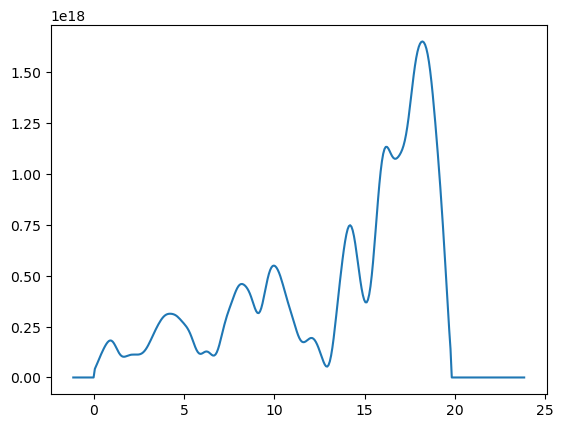

In [130]:
plt.plot(time_opt, momentrate_opt)